In [1]:
import numpy
import py_entropy
from matplotlib import pyplot
import os
import scipy.special

from tqdm.notebook import tqdm

pyplot.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

In [2]:
output_dir = "half_purity"

os.makedirs(output_dir, exist_ok=True)

In [3]:
def dephase_site(site, probs_and_states):
    all_ps_ss = []
    for p,s in probs_and_states:
        (pa,sa), (pb,sb) = s.trace_out_site(site)
        if pa > 0.0:
            all_ps_ss.append((p*pa, sa))
        if pb > 0.0:
            all_ps_ss.append((p*pb, sb))
    return all_ps_ss

def dephase_sites(start,end,probs_and_states):
    for i in range(start, end):
        probs_and_states = dephase_site(i, probs_and_states)
    return probs_and_states

In [4]:
n = 8
ne = 2000
k = 2000


input_states = []
for i in range(n):
    for j in range(i+1,n):
        input_states.append([i,j])
input_states = numpy.array(input_states).astype(numpy.uint64)
D = len(input_states)
amplitudes = numpy.ones((len(input_states)), dtype=numpy.complex128) / numpy.sqrt(D)
ps = py_entropy.MultidefectPureState(input_states, amplitudes)

# First dephase the last half and see what purity does
initial_probs_and_states = dephase_sites(n//2,n,[(1.0,ps)])
initial_half_purity = sum(p**2 for p,_ in initial_probs_and_states)

probs_and_states = dephase_sites(0,i,[(1.0, ps)])

s = py_entropy.MultiDefectState.new_pure(ps,
                                n,
                                num_experiments=ne, 
                                skip_float_checks=True)
initial_purity = s.get_mean_purity()
s.apply_alternative_layers(k)
_, amps = s.get_state()
sub_purities = []
for amp in amps:
    sub_ps = py_entropy.MultidefectPureState(input_states, amp[0,:] / numpy.sqrt(sum(numpy.abs(amp[0,:])**2)))
    sub_probs_and_states = dephase_sites(n//2,n,[(1.0,sub_ps)])
    sub_purity = sum(p**2 for p,_ in sub_probs_and_states)
    sub_purities.append(sub_purity)
sub_purities = numpy.array(sub_purities)


In [5]:
initial_half_purity

0.13520408163265307

In [6]:
sub_purities.mean()

0.16462924893370068

In [7]:
trace_sites = list(range(n//2))

s = py_entropy.MultiDefectState.new_pure(ps,
                                n,
                                num_experiments=ne, 
                                skip_float_checks=True)
initial_purity = s.get_mean_purity()
initial_trace_purity = s.get_trace_purity(trace_sites)
purity, trace_purity = s.apply_alternative_layers_and_save_mean_purity_and_trace_purity(k,trace_sites)

purity = numpy.hstack([[initial_purity], purity])
trace_purity = numpy.hstack([[initial_trace_purity], trace_purity])

initial_purity, initial_trace_purity

(0.03571428571428559, 0.4183673469387727)

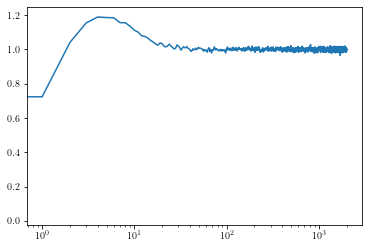

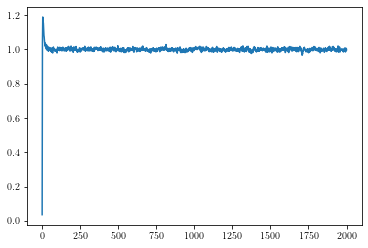

In [8]:
pyplot.plot(purity)
pyplot.xscale('log')
pyplot.show()

pyplot.plot(purity)
pyplot.show()

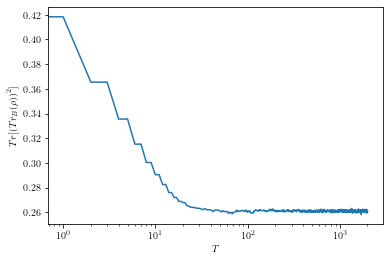

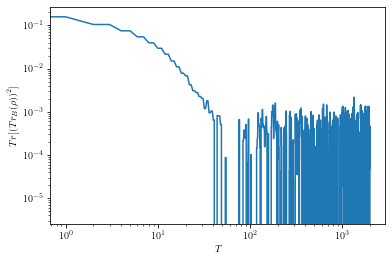

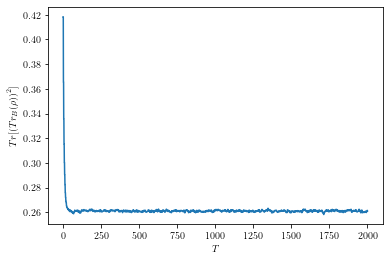

0.26103902327748474

In [9]:
pyplot.plot(trace_purity)
pyplot.xscale('log')
pyplot.ylabel(r'$Tr[\left( Tr_B (\rho) \right)^2]$')
pyplot.xlabel(r'$T$')
pyplot.show()

pyplot.plot(trace_purity - trace_purity[-1000:].mean())
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.ylabel(r'$Tr[\left( Tr_B (\rho) \right)^2]$')
pyplot.xlabel(r'$T$')
pyplot.show()

pyplot.plot(trace_purity)
pyplot.ylabel(r'$Tr[\left( Tr_B (\rho) \right)^2]$')
pyplot.xlabel(r'$T$')
pyplot.show()

trace_purity[-1000:].mean()

In [10]:
ns = 2*numpy.arange(1,20)
ne = 1000
k = 2000

filename = os.path.join(output_dir, "subsystem_purity.npz")

if os.path.exists(filename):
    arr = numpy.load(filename)
    all_purities = arr['data']
    all_trace_purities = arr['subsystem_data']
    ns = arr['ls']
else:
    all_purities = []
    all_trace_purities = []

    for n in tqdm(ns):
        input_states = []
        for i in range(n):
            for j in range(i+1,n):
                input_states.append([i,j])
        input_states = numpy.array(input_states).astype(numpy.uint64)
        D = len(input_states)
        amplitudes = numpy.ones((len(input_states)), dtype=numpy.complex128) / numpy.sqrt(D)
        ps = py_entropy.MultidefectPureState(input_states, amplitudes)

        trace_sites = list(range(n//2))

        s = py_entropy.MultiDefectState.new_pure(ps,
                                        n,
                                        num_experiments=ne, 
                                        skip_float_checks=True)
        initial_purity = s.get_mean_purity()
        initial_trace_purity = s.get_trace_purity(trace_sites)
        purity, trace_purity = s.apply_alternative_layers_and_save_mean_purity_and_trace_purity(k,trace_sites)

        purity = numpy.hstack([[initial_purity], purity])
        trace_purity = numpy.hstack([[initial_trace_purity], trace_purity])
        all_purities.append(purity)
        all_trace_purities.append(trace_purity)
    all_purities = numpy.array(all_purities)
    all_trace_purities = numpy.array(all_trace_purities)
    numpy.savez(data=all_purities,subsystem_data=all_trace_purities,ls=ns)

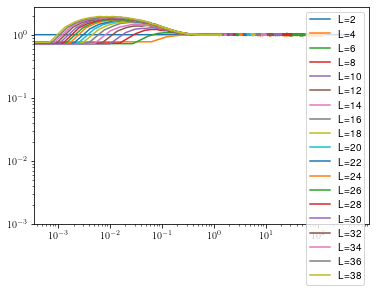

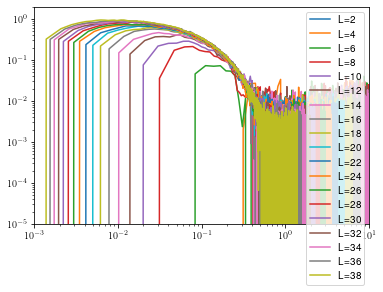

In [11]:
for n,purity in zip(ns,all_purities):
    pyplot.plot(numpy.arange(len(purity))/n**2, purity, label=f"L={n}")
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.legend(loc='upper right')
pyplot.show()

for n,purity in zip(ns,all_purities):
    pyplot.plot(numpy.arange(len(purity))/n**2, purity - 1.0, label=f"L={n}")
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.ylim([1e-5,2e0])
pyplot.xlim([1e-3,1e1])
pyplot.legend(loc='upper right')
pyplot.show()

$Tr[(Tr_B \rho)^2]$

In [12]:
def theory(L):
    return (-16 + L*(12 + L*(4 + L)))/(8*(-1 + L)*(2 + (-1 + L)*L))

def uniform_theory(L):
    return (4 + L*(3*L - 4))/(8*(L-1)**2)

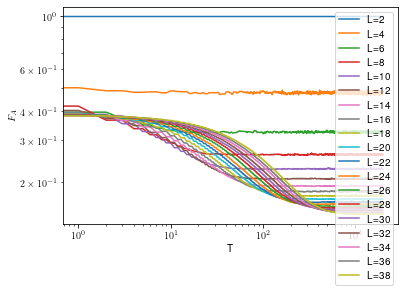

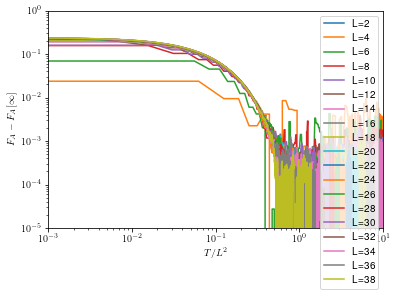

In [13]:
for n,trace_purity in zip(ns,all_trace_purities):
    pyplot.plot(numpy.arange(len(trace_purity)), trace_purity, label=f"L={n}")
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlabel('T')
pyplot.ylabel('$F_A$')
pyplot.legend(loc='upper right')
pyplot.show()

for n,trace_purity in zip(ns,all_trace_purities):
    pyplot.plot(numpy.arange(len(trace_purity))/n**2, trace_purity - theory(n), label=f"L={n}")
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlabel('$T/L^2$')
pyplot.ylabel('$F_A - F_A[\infty]$')
pyplot.ylim([1e-5,1e0])
pyplot.xlim([1e-3,1e1])
pyplot.legend(loc='upper right')
pyplot.show()

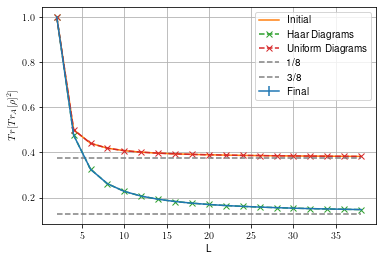

In [23]:
pyplot.errorbar(ns, all_trace_purities[:,-1000:].mean(axis=-1), yerr=all_trace_purities[:,-1000:].std(axis=-1), label='Final')
pyplot.plot(ns, all_trace_purities[:,0], label='Initial')
pyplot.plot(ns, theory(ns), 'x--', label='Haar Diagrams')
pyplot.plot(ns, uniform_theory(ns), 'x--', label='Uniform Diagrams')
pyplot.plot(ns, [1.0/8]*len(ns), '--', c='grey', label='1/8')
pyplot.plot(ns, [3.0/8]*len(ns), '--', c='grey', label='3/8')
pyplot.legend()
pyplot.grid()
pyplot.ylabel(r'$Tr[Tr_A[\rho]^2]$')
pyplot.xlabel('L')
pyplot.show()